# A Data Science Report on How to Win League of Legends
## Group 95:
>James D'Ugo <br>
>Edward Pan <br>
>Aarya Hattangdi <br>
>Sarro Aghrel <br>

## Introduction:
League of Legends (LOL) is a free-to-play, Multiplayer Online Battle Arena (MOBA) video game that was developed by Riot Games in 2009. 

The game involves two teams of five players that occupy and defend their half of the map. Each of the ten players then control a “champion” that has unique abilities and playstyles. Throughout the duration of the game, players make conscious decisions that make their champions stronger, using any advantage given to eventually push to the enemy base, and destroy their “Nexus”.  The mode we will be analysing is a competitive mode known as “Ranked Solo/Duo” which ranks a player based on their wins and losses. 

## Our Questions:

* What are the main factors that influence the likelihood of winning in each rank? 

* Is it possible to create an accurate model that can help predict the outcome of a match prior to or during the game? 

For simplicity we will be creating models for the Iron and Platinum ranks datasets and will be comparing their models.

## Explanation of Data Source
The data is generated through an API provided by Riot Games. We have used their methods to find information such as player information, their match history and each match's information. Through tedious formatting and filtering, we have been able to generate a database of match information for rach rank. This process has been further documented in the [MatchReader](MatchReader.ipynb)  file.

### Importing Libraries

In [69]:
from os import listdir
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

%matplotlib inline

## Data exploration

To reiterate an observation that was written about in the [MatchReader](MatchReader.ipynb)  file, each database is a collection of player match histories which have been filtered for ranked. In most cases, since not every game recorded in a player's match history will be ranked, there is inconsistency in database sizes between ranks.

Since the database creates two records for each game the number of records has doubled what was discussed initially (initially 334 recorded matches in iron and now 668 records).

Although, this does not change the observation; higher the rank, greater the proportion of games from their match history are ranked (iron with 668 records and diamond with 984). This may imply that iron players care less about ranked and enjoy/focus on other aspects of the game more whereas diamond players feel the need to consistently play ranked.

In [324]:
#list directory of all csv files stored in data folder
CSV_Files = [file for file in listdir('Data/') if file.endswith('.csv') ]
print(CSV_Files)

['bronze.csv', 'diamond.csv', 'gold.csv', 'iron.csv', 'platinum.csv', 'silver.csv']


In [325]:
#reading the csv files

csvs = []
for file in CSV_Files:

    data = pd.read_csv('Data/' + file)
    csvs.append(data)

csvs[1].head()

,matchId,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,...,1ban3,1ban4,1ban5,2ban1,2ban2,2ban3,2ban4,2ban5,teamId,win
0,OC1_490546013,193,3,0,7,2808,641,0,49,45,...,7,711,64,350,236,164,104,-1,100,True
1,OC1_490546013,193,1,0,6,2021,1477,18,73,21,...,7,711,64,350,236,164,104,-1,200,False
2,OC1_490545140,1497,106,9,17,83249,27260,489,755,536,...,91,-1,7,35,350,53,267,8,200,True
3,OC1_490545140,1497,108,4,12,55430,16390,838,1171,515,...,91,-1,7,35,350,53,267,8,100,False
4,OC1_490534745,1238,108,11,20,60677,13063,303,553,519,...,64,246,236,14,104,111,81,107,100,True


In [326]:
RANKS = ['Bronze', 'Diamond', 'Gold', 'Iron', 'Platinum', 'Silver']
for i,csv in enumerate(csvs):
    print("{0}, size: {1}".format(RANKS[i],csv.shape[0]))

Bronze, size: 804
Diamond, size: 984
Gold, size: 832
Iron, size: 668
Platinum, size: 900
Silver, size: 944


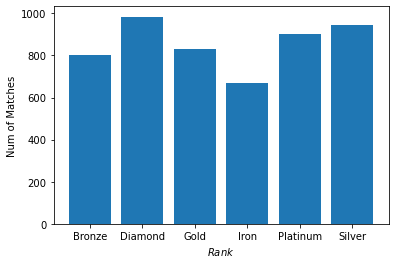

In [327]:
sizes=list(csv.shape[0] for csv in csvs)
plt.bar(RANKS,sizes)
plt.xlabel('$Rank$')
plt.ylabel('Num of Matches')
plt.show()

### Context:
The **first heatmap represents Iron** and is denoted by the index 3 in the csvs list (**csvs[3]**). The **second heatmap represents Plantinum** and has the index of 4 (**csvs[4]**). This may be slightly confusing as the files are read/stored in **alphabetical order** whereas the official ranked order from lowest to highest is 'IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND'.

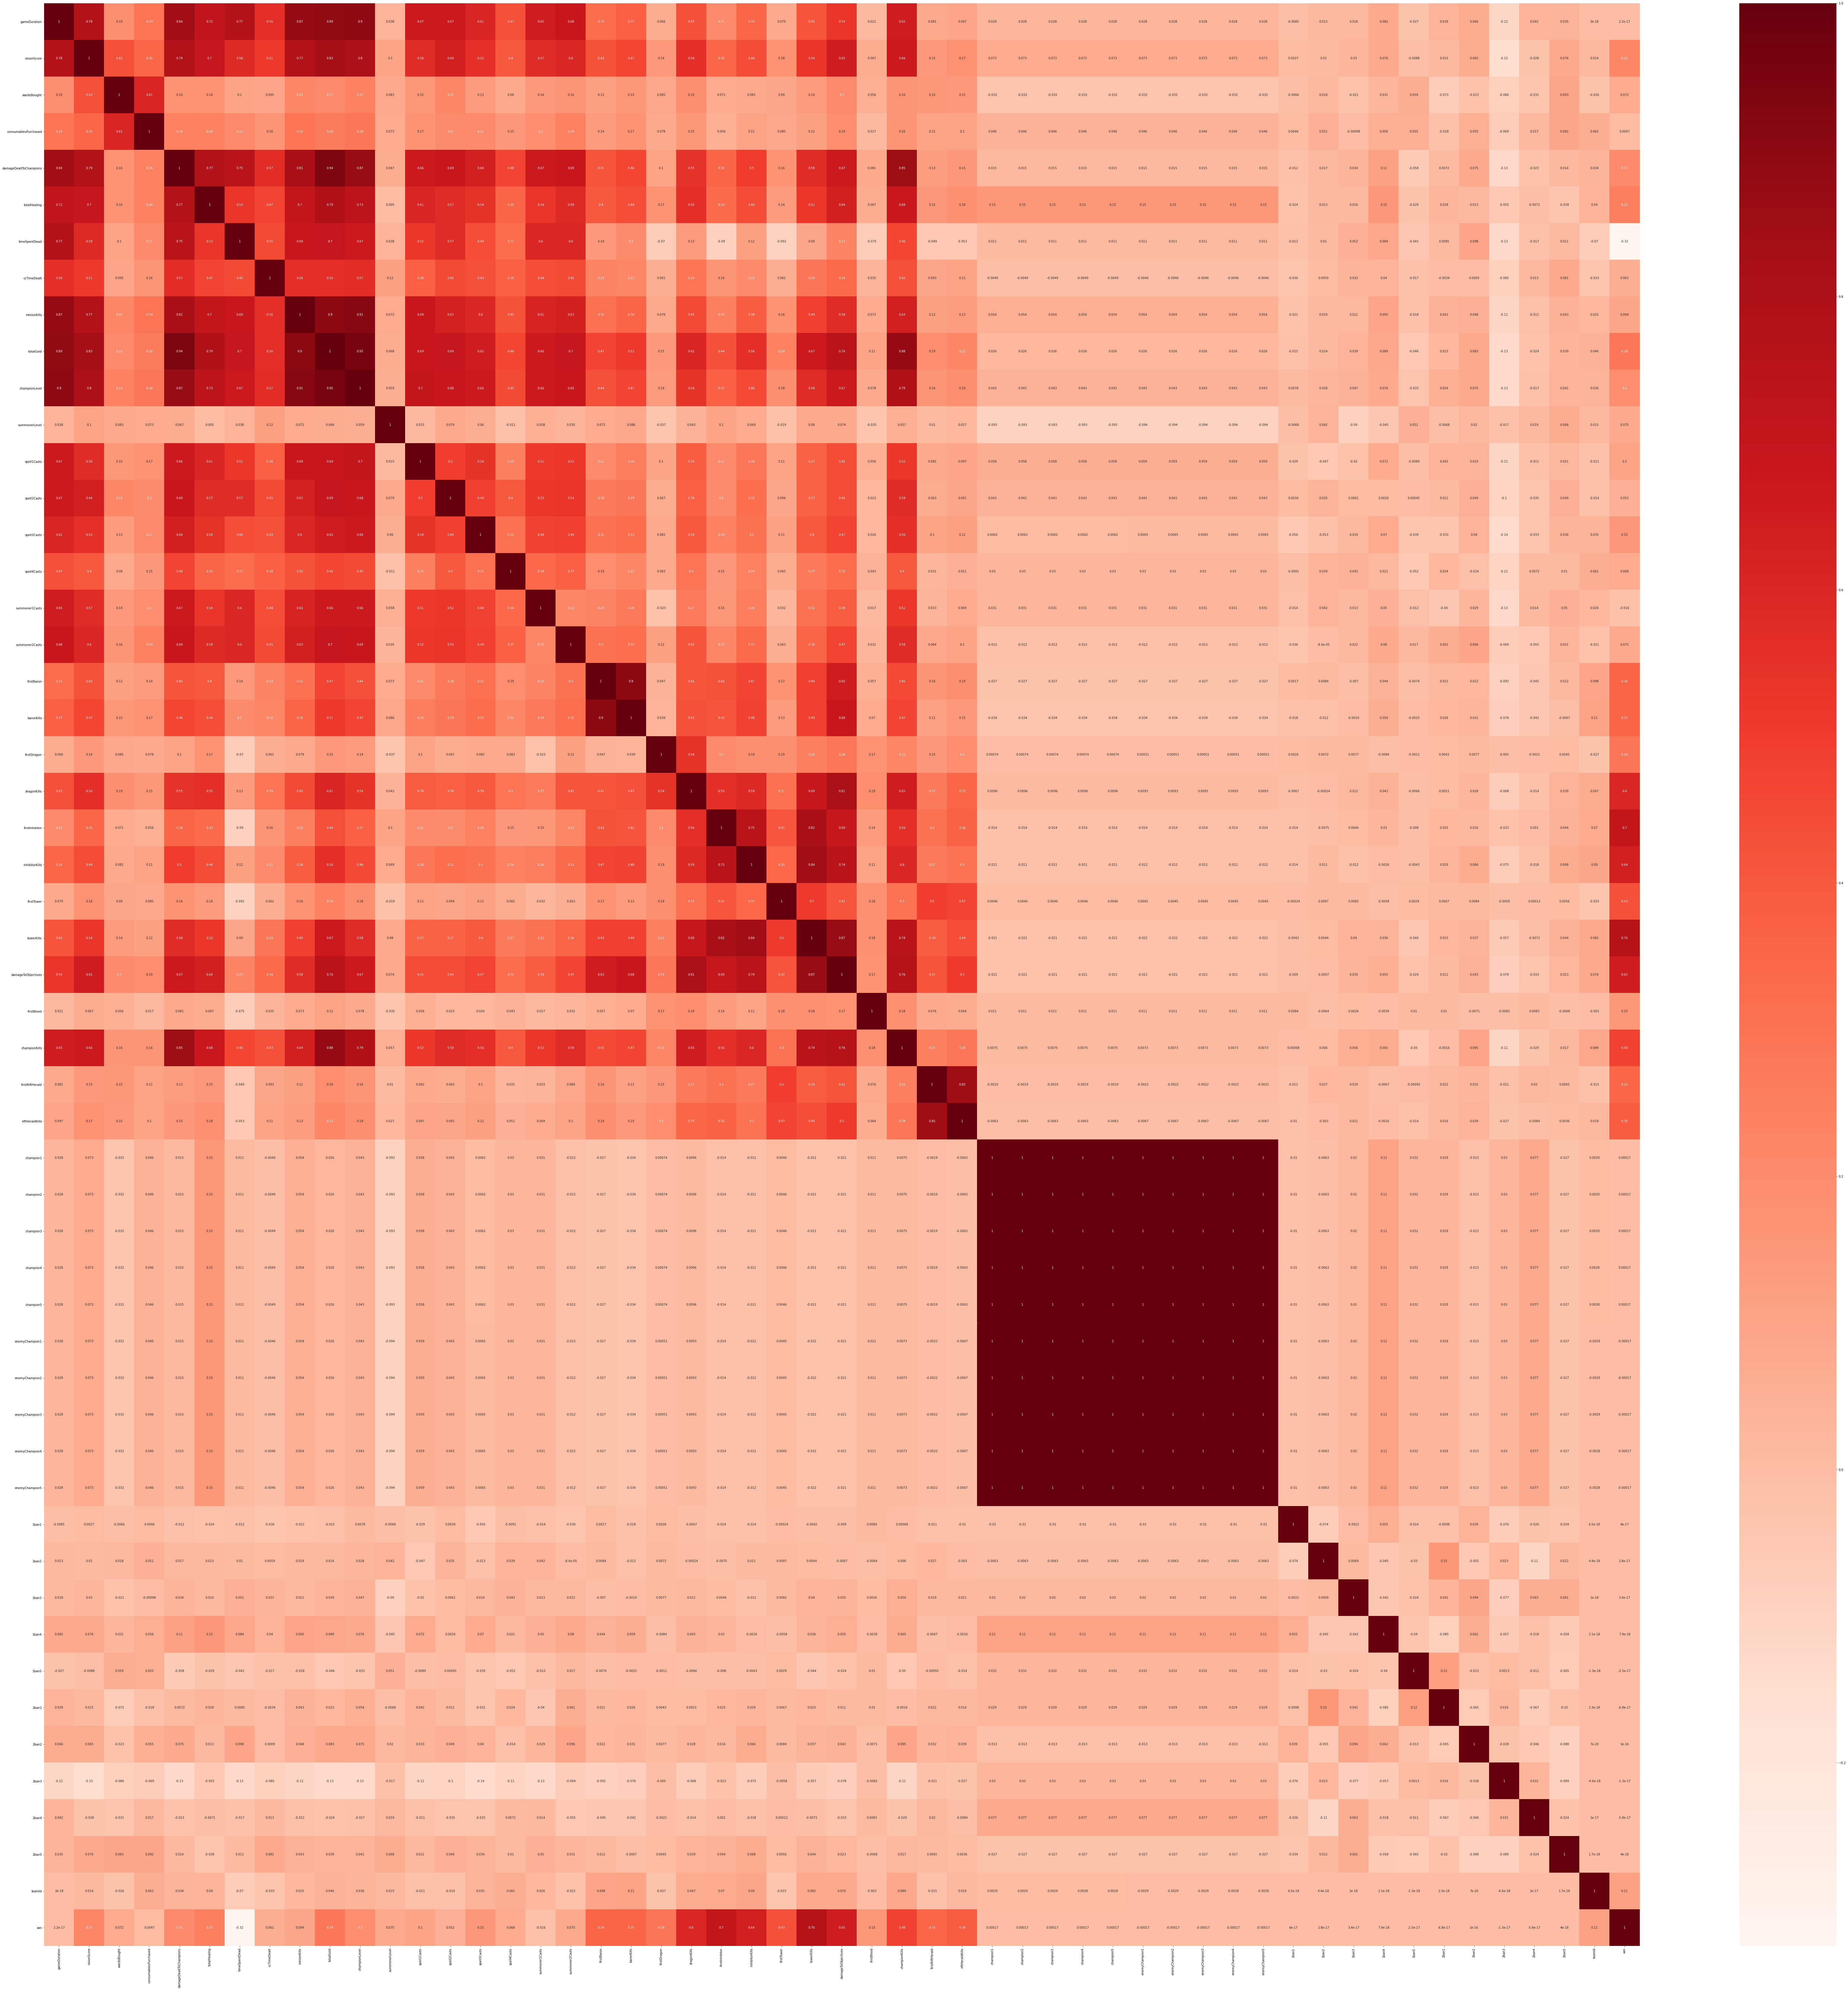

In [288]:
X = csvs[3].drop("win", axis =1)   #Feature Matrix
y = csvs[3]["win"]          #Target Variable

plt.figure(figsize=(120,120))
cor = csvs[3].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

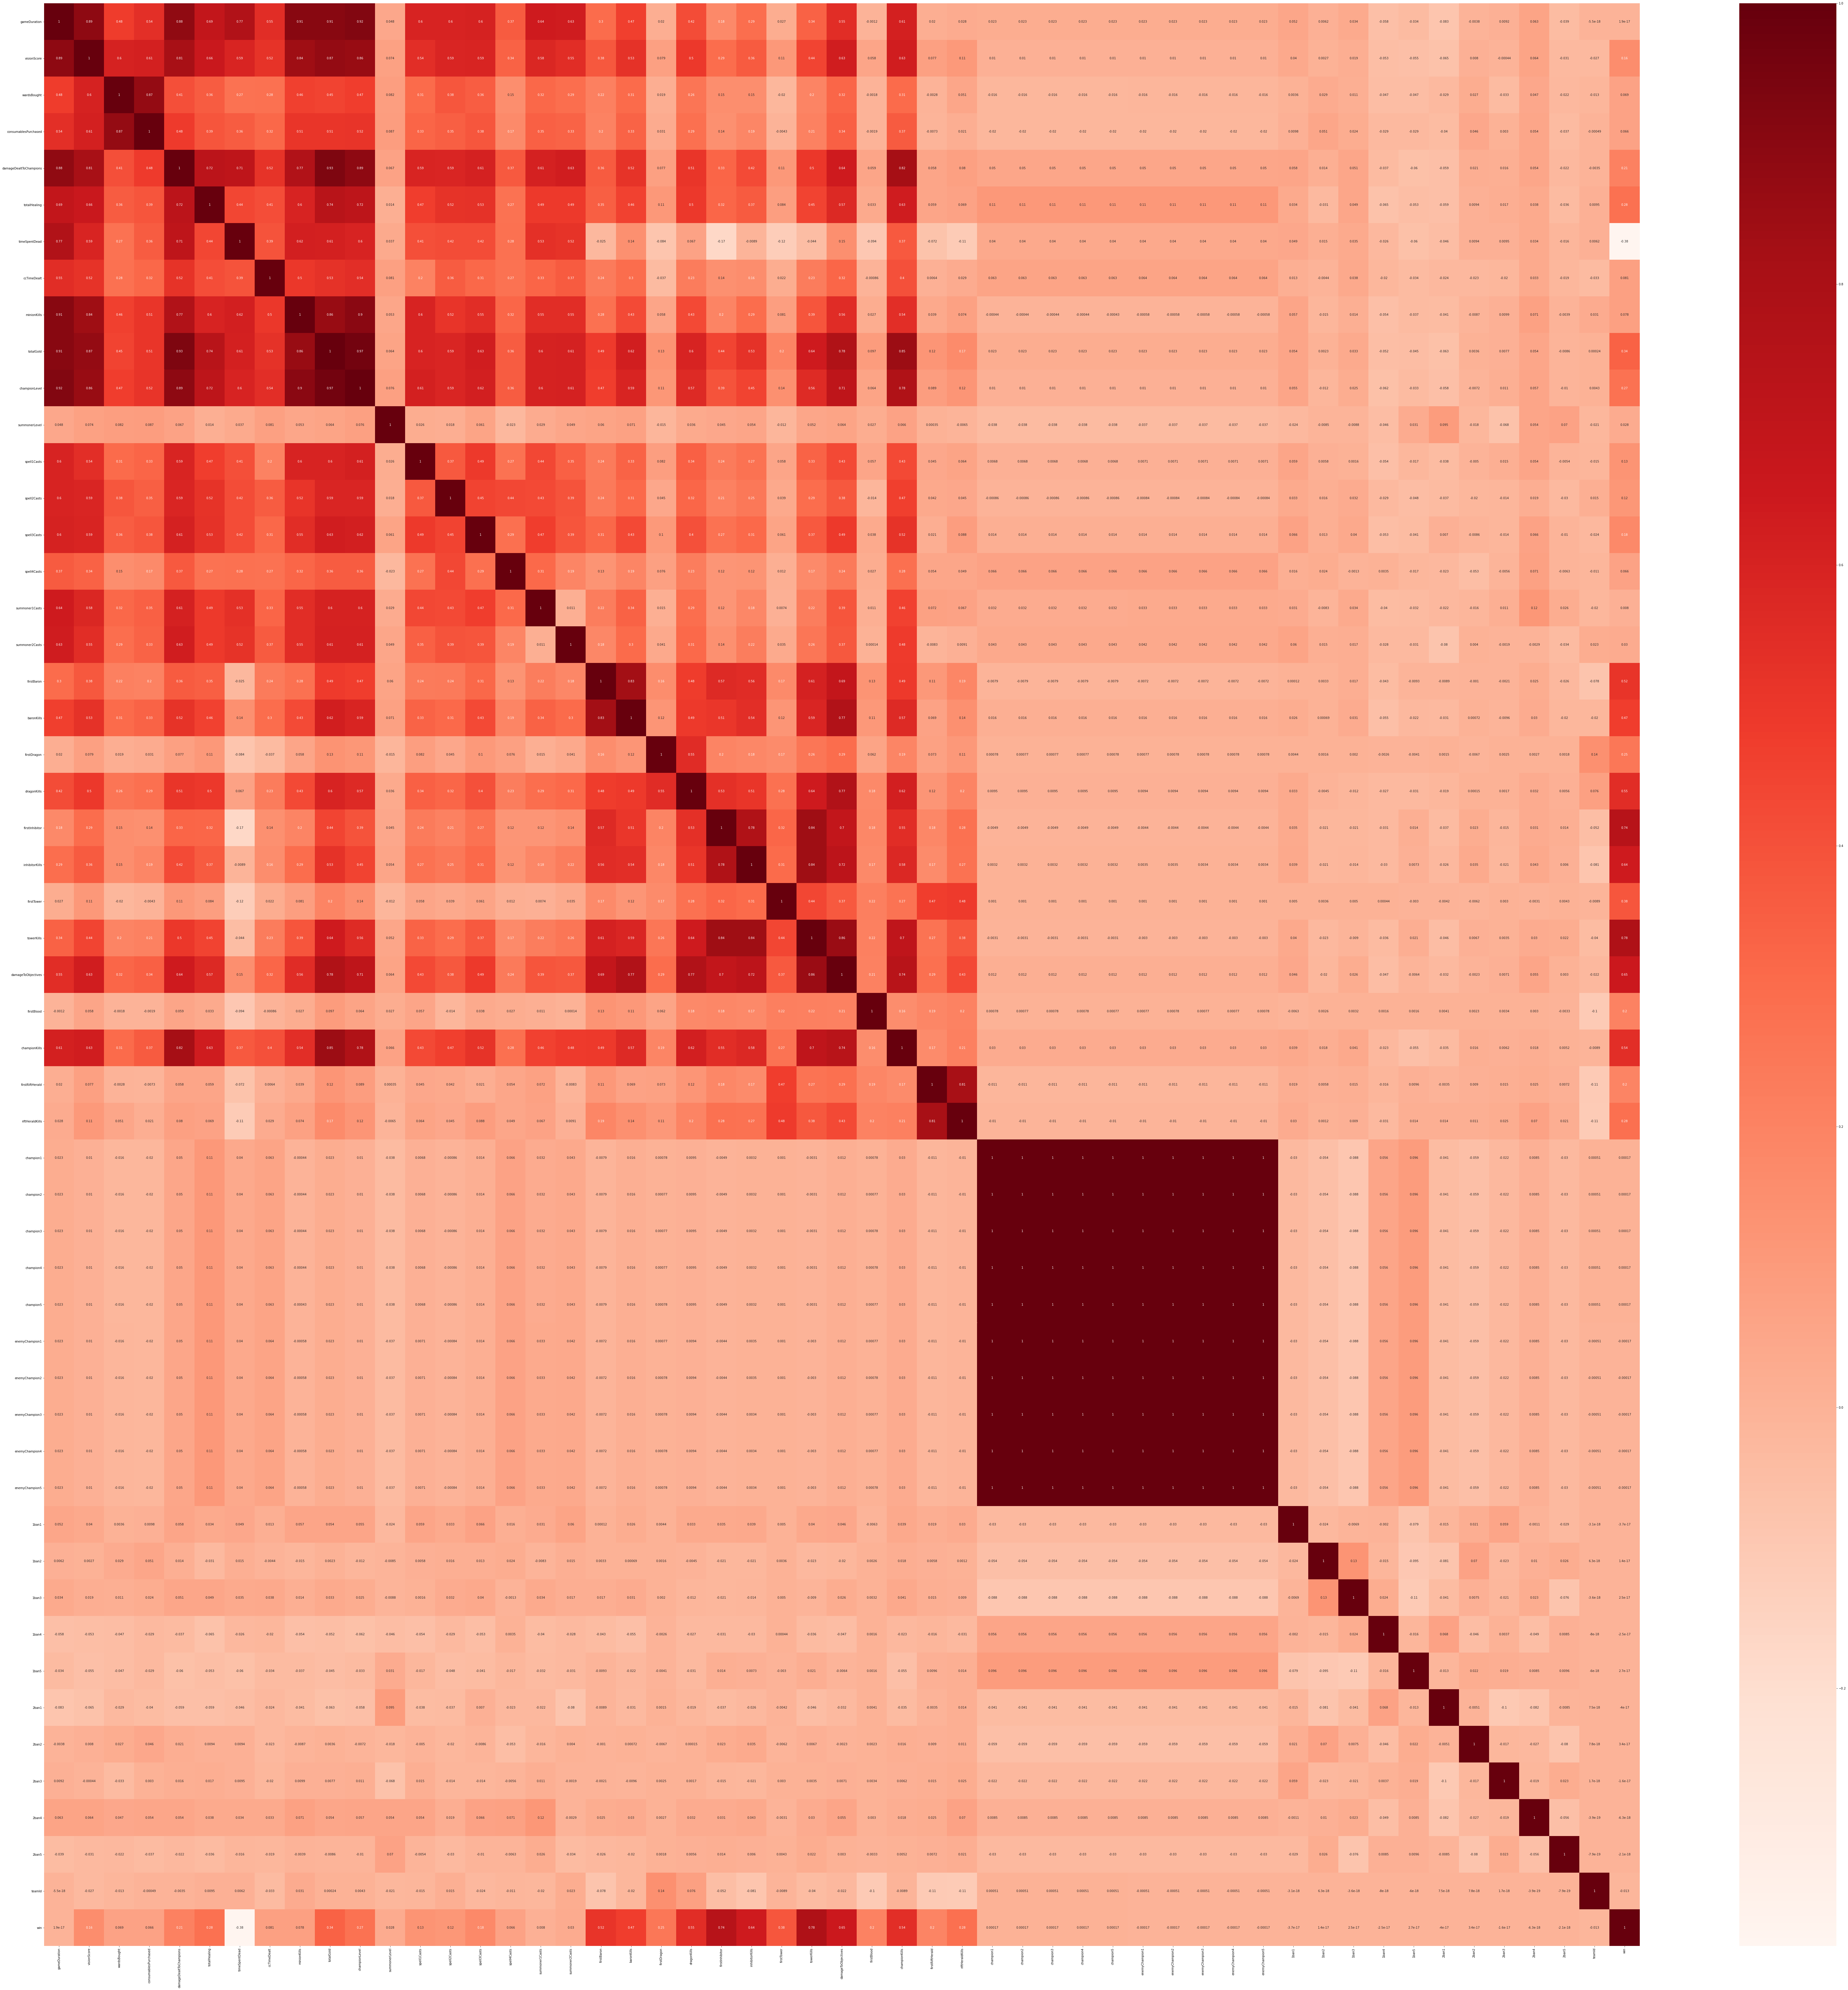

In [289]:
X = csvs[4].drop("win", axis =1)   #Feature Matrix
y = csvs[4]["win"]          #Target Variable

plt.figure(figsize=(120,120))
cor = csvs[4].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

From the heatmap we can see the values that strongly correlate to winning. If the value is close to 1 then a strong positive correlation is implied. If the value is close to -1 then a strong negative correlation is implied. If the value is close then it can be said there is not much correlation. Here, we can see the factors that correlate most to winning are dragonkills, firstinhibitor, inhibitorkills, towerkills and damageToObjectives. 

It is seen that there is less of a correlation in iron between firstBaron and Championkills in relation to winning with a value of 0.36 and 0.48 respectivley. Whilst, in the rank of platinum there is a much higher correlation between firstBaron and Champion kills with a value of 0.52 and 0.54. 

This means in higher ranks getting the Baron objective first and champion kills plays more importance towards winning as they can better translate those factors into a victory.

In [346]:
# Simple Linear regression in Iron
reg = linear_model.LinearRegression()
X = csvs[3][['firstBaron', 'championKills']]
y = csvs[3][['win']]
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[0.20320443 0.01482306]] + [0.01237455]


In [347]:
predicted = reg.predict(X)
mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.18620000029801126
R Squared: 0.25519999880795496


In [348]:
#Simple Linear regression in Platinum
reg = linear_model.LinearRegression()
X = csvs[4][['firstBaron', 'championKills']]
y = csvs[4][['win']]
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [[0.34190545 0.01589065]] + [-0.07642983]


In [349]:
predicted = reg.predict(X)
mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.15543635555876706
R Squared: 0.37825457776493177


The result of the simple linear regression shows that there is a greater correlation between winning and firstBaron and champion kills in platinum with an R-squared value of 0.39 in comparison to the value in iron at 0.26. Overall, there is not a strong correlation between winning and these factors as we can see R-squared for both regressions are below 0.5. We will continue to analyse the data set using different models to help find the features that mainly contribute to winning a game. 

In [294]:
csvs[3].describe()

,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,totalGold,...,1ban2,1ban3,1ban4,1ban5,2ban1,2ban2,2ban3,2ban4,2ban5,teamId
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,...,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,1734.086826,93.929641,5.011976,14.459581,79698.052395,27303.651198,885.878743,1009.309880,476.366766,50939.986527,...,149.098802,147.970060,126.883234,140.844311,147.742515,156.302395,147.628743,129.958084,149.622754,150.000000
std,486.454247,40.775718,3.851031,6.098874,37991.263080,15113.730702,497.646369,547.084993,142.156349,16185.830422,...,184.207771,187.750686,158.251981,165.762008,191.643690,193.688636,182.183294,169.260845,190.834799,50.037467
min,200.000000,0.000000,0.000000,3.000000,872.000000,130.000000,0.000000,13.000000,14.000000,4052.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,100.000000
25%,1446.000000,66.000000,2.000000,10.000000,51664.750000,16311.250000,518.000000,629.750000,392.750000,41025.500000,...,32.000000,35.000000,25.000000,36.000000,25.000000,35.000000,35.000000,25.000000,32.000000,100.000000
50%,1766.500000,91.000000,4.000000,14.000000,77276.500000,25111.000000,845.500000,897.500000,478.000000,51040.000000,...,91.000000,86.500000,75.000000,84.000000,86.500000,99.000000,83.000000,77.000000,84.000000,150.000000
75%,2029.000000,119.000000,7.000000,18.000000,102755.250000,35139.000000,1178.500000,1277.750000,558.000000,61482.000000,...,157.000000,157.000000,157.000000,157.000000,157.000000,202.000000,164.000000,141.000000,157.000000,200.000000
max,3972.000000,279.000000,20.000000,38.000000,245008.000000,98987.000000,2897.000000,3581.000000,946.000000,100524.000000,...,887.000000,887.000000,777.000000,876.000000,887.000000,875.000000,875.000000,875.000000,875.000000,200.000000


In [295]:
csvs[4].describe()

,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,totalGold,...,1ban2,1ban3,1ban4,1ban5,2ban1,2ban2,2ban3,2ban4,2ban5,teamId
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,1654.093333,130.802222,12.802222,20.850000,80719.180000,27254.490000,801.382222,1029.658889,563.474444,53167.300000,...,176.288889,177.593333,180.993333,188.444444,196.955556,185.133333,171.248889,179.400000,186.808889,150.000000
std,379.755603,48.051636,5.783910,6.827996,33865.214537,14216.707434,423.144483,480.873018,127.859595,14249.815939,...,205.128693,202.423507,198.781925,206.449110,225.222674,196.110307,194.331701,205.675079,205.578981,50.027801
min,192.000000,1.000000,0.000000,4.000000,1654.000000,5.000000,0.000000,31.000000,31.000000,4381.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,100.000000
25%,1417.000000,97.000000,9.000000,16.000000,56643.250000,16737.250000,482.750000,689.750000,485.750000,43836.000000,...,38.000000,39.000000,39.000000,53.000000,38.000000,39.000000,39.000000,39.000000,39.000000,100.000000
50%,1658.500000,130.500000,12.000000,20.000000,77397.500000,25419.000000,775.000000,937.000000,566.500000,53202.000000,...,105.000000,111.000000,114.000000,118.000000,117.000000,114.000000,118.000000,112.500000,117.000000,150.000000
75%,1895.000000,161.000000,16.000000,25.000000,99721.500000,34800.750000,1047.750000,1288.500000,646.000000,62483.500000,...,235.000000,234.000000,238.000000,245.000000,238.000000,245.000000,223.000000,238.000000,238.000000,200.000000
max,2803.000000,285.000000,39.000000,56.000000,198812.000000,109085.000000,2604.000000,3547.000000,1005.000000,94625.000000,...,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,200.000000


From the data it can be observed that Platinum tends to outperform Iron in many of the fields. Some basic comparison shows that Platinum players better prioritise visionscore and the wardsbought. Games also tend to be finished quicker in Platinum and players spend less time dead.

## Data Preparation
We have removed games with less that 10 mins of gameDuration since they represent remakes or early surrenders. This only occurs when a player has disconnected from the game. This experience is not an accurate representation of the average ranked game and therefore is treated as an outlier.

We have also represented categorical data such as 'win', and whether or not a team got an objective first (e.g. 'firstBaron') into a numerical value (0 or 1). This made the most sense due to the boolean data type that they were initially stored as. This allows the field to be handled when we create our models. 

In [296]:
x = range(6)
for data in x:
    csvs[data] = csvs[data][csvs[data].gameDuration > 600] #removing games less than 10mins long, ie.games that are a "remake"

In [297]:
bronze = csvs[0]
bronze.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 0 to 803
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   matchId                 796 non-null    object
 1   gameDuration            796 non-null    int64 
 2   visionScore             796 non-null    int64 
 3   wardsBought             796 non-null    int64 
 4   consumablesPurchased    796 non-null    int64 
 5   damageDealtToChampions  796 non-null    int64 
 6   totalHealing            796 non-null    int64 
 7   timeSpentDead           796 non-null    int64 
 8   ccTimeDealt             796 non-null    int64 
 9   minionKills             796 non-null    int64 
 10  totalGold               796 non-null    int64 
 11  championLevel           796 non-null    int64 
 12  summonerLevel           796 non-null    int64 
 13  spell1Casts             796 non-null    int64 
 14  spell2Casts             796 non-null    int64 
 15  spell3

In [298]:
pd.options.mode.chained_assignment = None

def categorise(df,column):
    df[column+'_cat'] = data[column].astype('category').cat.codes
    data.drop([column], axis=1, inplace=True)
    
categories = ['win','firstBaron','firstDragon','firstInhibitor','firstTower','firstBlood','firstRiftHerald']

for data in csvs:
    for category in categories:
        categorise(data,category)
    data.drop(['matchId'], axis = 1, inplace=True)

csvs[3]

,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,totalGold,...,2ban4,2ban5,teamId,win_cat,firstBaron_cat,firstDragon_cat,firstInhibitor_cat,firstTower_cat,firstBlood_cat,firstRiftHerald_cat
0,1852,56,1,10,95606,36654,878,824,518,60502,...,157,111,200,1,1,0,1,1,1,1
1,1852,105,3,5,74843,23935,1178,1233,423,48079,...,157,111,100,0,0,1,0,0,0,0
2,1854,121,4,16,102117,34586,968,1336,626,61600,...,84,526,200,1,0,1,1,0,0,0
3,1854,67,3,21,74015,27955,1270,1397,502,51081,...,84,526,100,0,0,0,0,1,1,1
4,1448,63,3,8,51209,23131,383,2300,414,37044,...,122,7,100,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2932,201,13,29,156630,75731,1994,1710,888,88582,...,120,42,200,0,0,1,0,0,1,1
664,1211,64,1,9,51592,21532,341,1356,348,38903,...,141,42,200,1,0,1,0,1,1,1
665,1211,43,2,13,35524,8317,631,441,324,31148,...,141,42,100,0,0,0,0,0,0,0
666,1382,73,9,18,61934,15846,349,990,398,44451,...,8,523,100,1,0,1,0,1,1,1


# Data Analysis and Modelling (Iron):

## RFE: Logistic Regression

In [299]:
#this analysis is currently only performed on iron dataset
train, test = train_test_split(csvs[3], test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(523, 53)
(131, 53)


In [300]:
X_train = train.drop(['win_cat'], axis=1)
y_train = train['win_cat']
X_test = test.drop(['win_cat'], axis=1)
y_test = test['win_cat']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
display(X_train.head())
display(y_train.head())

X_train shape:  (523, 52)
y_train shape:  (523,)
X_test shape:  (131, 52)
y_test shape:  (131,)


,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,totalGold,...,2ban3,2ban4,2ban5,teamId,firstBaron_cat,firstDragon_cat,firstInhibitor_cat,firstTower_cat,firstBlood_cat,firstRiftHerald_cat
375,1794,84,5,15,58601,16940,1036,933,501,50885,...,35,105,84,200,0,0,0,0,0,0
415,1480,67,2,13,44753,10125,637,635,482,37217,...,55,99,119,200,0,0,0,0,0,0
411,1368,48,3,17,49330,7585,623,273,348,34865,...,35,-1,711,200,0,0,0,0,0,0
389,1835,96,8,15,78342,22412,1084,1533,520,51079,...,36,254,11,200,0,1,0,0,0,0
261,2035,142,5,13,120422,25507,1891,2436,584,57507,...,122,19,99,200,0,0,0,1,0,1


375    0
415    0
411    0
389    0
261    0
Name: win_cat, dtype: int8

In [303]:
lr_model = LogisticRegression(solver='lbfgs', max_iter = 12000)
accuracy_list = []
for x in range(1,52):
    
    rfe = RFE(estimator=lr_model, n_features_to_select=x, step=1)
    rfe.fit(X_train, y_train)
    y_test_hat = rfe.predict(X_test)
    print("accuracy score on test set: ",x , accuracy_score(y_test, y_test_hat))
    accuracy_list.append(accuracy_score(y_test, y_test_hat))
    

accuracy score on test set:  1 0.5038167938931297
accuracy score on test set:  2 0.5419847328244275
accuracy score on test set:  3 0.7786259541984732
accuracy score on test set:  4 0.7786259541984732
accuracy score on test set:  5 0.7786259541984732
accuracy score on test set:  6 0.7709923664122137
accuracy score on test set:  7 0.7633587786259542
accuracy score on test set:  8 0.7633587786259542
accuracy score on test set:  9 0.7633587786259542
accuracy score on test set:  10 0.7633587786259542
accuracy score on test set:  11 0.7709923664122137
accuracy score on test set:  12 0.7709923664122137
accuracy score on test set:  13 0.8854961832061069
accuracy score on test set:  14 0.8854961832061069
accuracy score on test set:  15 0.8854961832061069
accuracy score on test set:  16 0.8854961832061069
accuracy score on test set:  17 0.8854961832061069
accuracy score on test set:  18 0.8854961832061069
accuracy score on test set:  19 0.8854961832061069
accuracy score on test set:  20 0.877862

(0.4, 1.0)

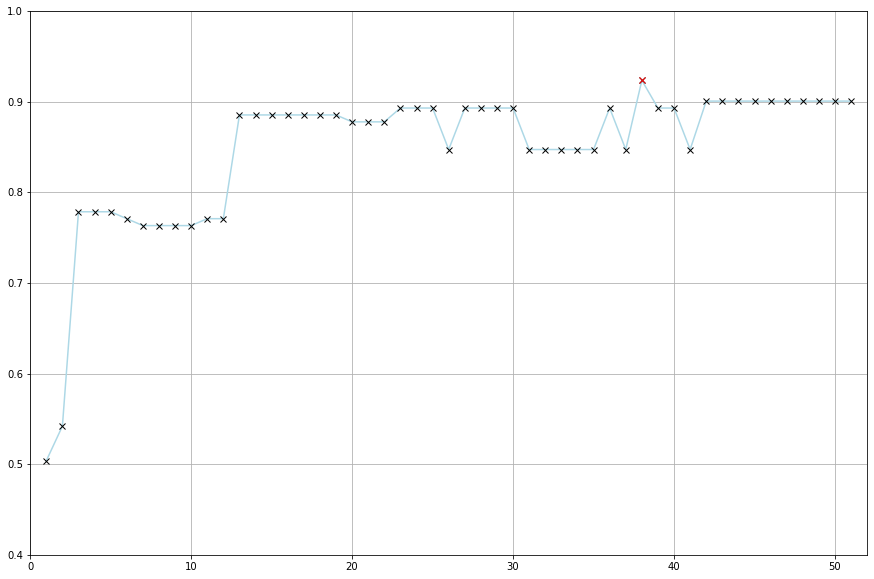

In [304]:
plt.figure(figsize=(15,10))
plt.grid()
plt.plot(range(1,52),accuracy_list, marker = 'x', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'black')
plt.plot(accuracy_list.index(max(accuracy_list)) + 1, accuracy_list[accuracy_list.index(max(accuracy_list))], marker = 'x', markeredgecolor = 'red', markerfacecolor = 'None')
plt.xlim([0,52])
plt.ylim([0.4,1])

In [305]:
print('highest accuracy model: ' + str(accuracy_list.index(max(accuracy_list)) + 1) + " " + str(max(accuracy_list)))
features = accuracy_list.index(max(accuracy_list)) + 1

highest accuracy model: 38 0.9236641221374046


In [306]:
from sklearn.tree import DecisionTreeClassifier
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=features)
rfe.fit(X_train, y_train)
for i in range(X_train.shape[1]):
    if(rfe.support_[i] == True):
        print('Column: %d, Rank: %.0f' % (i,  rfe.ranking_[i]) + " " + X_train.columns[i])

Column: 3, Rank: 1 consumablesPurchased
Column: 4, Rank: 1 damageDealtToChampions
Column: 5, Rank: 1 totalHealing
Column: 6, Rank: 1 timeSpentDead
Column: 7, Rank: 1 ccTimeDealt
Column: 8, Rank: 1 minionKills
Column: 9, Rank: 1 totalGold
Column: 10, Rank: 1 championLevel
Column: 11, Rank: 1 summonerLevel
Column: 12, Rank: 1 spell1Casts
Column: 13, Rank: 1 spell2Casts
Column: 14, Rank: 1 spell3Casts
Column: 15, Rank: 1 spell4Casts
Column: 16, Rank: 1 summoner1Casts
Column: 17, Rank: 1 summoner2Casts
Column: 18, Rank: 1 baronKills
Column: 19, Rank: 1 dragonKills
Column: 20, Rank: 1 inhibitorKills
Column: 21, Rank: 1 towerKills
Column: 23, Rank: 1 championKills
Column: 31, Rank: 1 enemyChampion2
Column: 32, Rank: 1 enemyChampion3
Column: 33, Rank: 1 enemyChampion4
Column: 34, Rank: 1 enemyChampion5
Column: 35, Rank: 1 1ban1
Column: 36, Rank: 1 1ban2
Column: 37, Rank: 1 1ban3
Column: 38, Rank: 1 1ban4
Column: 39, Rank: 1 1ban5
Column: 40, Rank: 1 2ban1
Column: 41, Rank: 1 2ban2
Column: 42,

By utilising recursive feature elimination we can find the most relevant features that help determine a win in a game. We start with a sample of data with all 52 features. It begins to remove features, from this we can then establish an accuracy score where we can see the optimal amount of features that help dictate the likelihood of the game ending in a win.

After running the rfe, we can see that the opitimal number of features need to predict a win in Iron division is 38. This allows a prediction to be made with an accuracy of approximately 92.4%. From the list above we can see the necessary features that help assist in predicting the likelihood of a win. 

## Gaussian Naive Bayes

In [307]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

In [308]:
clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('accuracy: '+ str(accuracy))

accuracy: 0.7633587786259542


In [309]:
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
print('Gaussian Naive Bayes accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (scores.min(), scores.max(), scores.mean(), scores.std()))

Gaussian Naive Bayes accuracy range: [0.7308, 0.8269]; mean: 0.7725; std: 0.0296



Gaussian naive bayes is an alternative to the multinomial naive bayes. Rather than following a discrete distribution it follows the Gaussian normal distribution allowing it to support continuous data. From the data, we can see that the accuracy range is approximately from 73.1% to 82.7%. We can see that this level of accuracy is lower than the previous models we have made and this can be attributed to the possibility that the data does not fit the density of a normal distribution resulting in a lower accuracy. Based on the results of the accuracy we can see this is a weaker model in comparison to the previous models. We will continue to explore different models to help understand the main features. 



## RandomForest

In [310]:
from sklearn.ensemble import ExtraTreesClassifier
scores = []
for i in range(10, 500, 30):
    forest = ExtraTreesClassifier(n_estimators=i, random_state=142)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    scores.append(accuracy)
    print(str(i) + ' estimator accuracy: '+ str(accuracy))

10 estimator accuracy: 0.8702290076335878
40 estimator accuracy: 0.9007633587786259
70 estimator accuracy: 0.8931297709923665
100 estimator accuracy: 0.9007633587786259
130 estimator accuracy: 0.9007633587786259
160 estimator accuracy: 0.9007633587786259
190 estimator accuracy: 0.9007633587786259
220 estimator accuracy: 0.9007633587786259
250 estimator accuracy: 0.9007633587786259
280 estimator accuracy: 0.9007633587786259
310 estimator accuracy: 0.9007633587786259
340 estimator accuracy: 0.9007633587786259
370 estimator accuracy: 0.9007633587786259
400 estimator accuracy: 0.9007633587786259
430 estimator accuracy: 0.9007633587786259
460 estimator accuracy: 0.9007633587786259
490 estimator accuracy: 0.9007633587786259


In [311]:
print('highest accuracy model: ' + str((scores.index(max(scores))*30) + 10) + " " + str(max(scores)))
estimators = (scores.index(max(scores))*30) + 10

highest accuracy model: 40 0.9007633587786259


In [312]:
forest = ExtraTreesClassifier(n_estimators = estimators, random_state=142)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
td = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
index = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, index[f], importances[index[f]]) + " " + X_train.columns[index[f]])

Feature ranking:
1. feature 48 (0.204937) firstInhibitor_cat
2. feature 21 (0.130859) towerKills
3. feature 22 (0.080175) damageToObjectives
4. feature 20 (0.059047) inhibitorKills
5. feature 19 (0.055964) dragonKills
6. feature 6 (0.043985) timeSpentDead
7. feature 49 (0.036532) firstTower_cat
8. feature 51 (0.028450) firstRiftHerald_cat
9. feature 24 (0.027880) riftHeraldKills
10. feature 0 (0.025939) gameDuration
11. feature 47 (0.022829) firstDragon_cat
12. feature 23 (0.020369) championKills
13. feature 46 (0.016004) firstBaron_cat
14. feature 9 (0.013827) totalGold
15. feature 8 (0.012304) minionKills
16. feature 18 (0.011888) baronKills
17. feature 10 (0.011000) championLevel
18. feature 13 (0.010970) spell2Casts
19. feature 16 (0.010063) summoner1Casts
20. feature 15 (0.008686) spell4Casts
21. feature 38 (0.008617) 1ban4
22. feature 1 (0.008392) visionScore
23. feature 4 (0.008249) damageDealtToChampions
24. feature 5 (0.007704) totalHealing
25. feature 36 (0.007361) 1ban2
26. 

Random Forests can be utilised in order to rank the features with most importance. The method works by creating a large number of trees that each output a class prediction. Once a class prediction is outputted by the individual trees then the class that has recieved the most votes will become the models prediction. This is very effective for our data set as we have a lot of uncorrelated fields meaning that each individual tree covers the out of bag error for the other trees giving an accurate result. This can bee seen by the relatively high level of accuracy which is approximately 90%. 

From the analysis, feature 48 which is known as the firstInhibotor seemed to play an important role in determing the outcome of the game. This is important to note as we can now better predict the outcome of a match in Iron based on which team has taken the first inhibitor.

## KNeighbors

In [313]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

k_range = range(1, 150, 5)
parameter_grid = {'n_neighbors':range(1, 150, 5)}
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy',cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_knn.fit(X_train, y_train)

print("Best K: ", gs_knn.best_params_['n_neighbors'])
print("Accuracy: ",gs_knn.best_score_)

Best K:  16
Accuracy:  0.8471335268505079


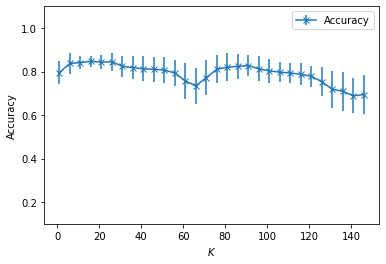

In [314]:
mean=gs_knn.cv_results_['mean_test_score']
std=gs_knn.cv_results_['std_test_score']

plt.errorbar(k_range, mean, yerr=std, marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('$K$')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Data Analysis and Modelling (Platinum):

## RFE: Logistic Regression

In [315]:
train, test = train_test_split(csvs[4], test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(716, 53)
(180, 53)


In [316]:
X_train = train.drop(['win_cat'], axis=1)
y_train = train['win_cat']
X_test = test.drop(['win_cat'], axis=1)
y_test = test['win_cat']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
display(X_train.head())
display(y_train.head())

X_train shape:  (716, 52)
y_train shape:  (716,)
X_test shape:  (180, 52)
y_test shape:  (180,)


,gameDuration,visionScore,wardsBought,consumablesPurchased,damageDealtToChampions,totalHealing,timeSpentDead,ccTimeDealt,minionKills,totalGold,...,2ban3,2ban4,2ban5,teamId,firstBaron_cat,firstDragon_cat,firstInhibitor_cat,firstTower_cat,firstBlood_cat,firstRiftHerald_cat
426,1459,120,9,19,79551,31556,410,1355,501,55157,...,887,234,350,100,1,1,1,1,1,1
639,1492,79,7,13,57796,14541,1028,594,475,36727,...,711,63,166,100,0,0,0,0,0,0
13,1657,118,7,16,74551,19389,1226,698,598,48655,...,164,141,21,200,0,1,0,1,1,0
720,1503,141,10,18,69021,20335,622,634,559,54319,...,32,54,523,100,1,1,1,0,1,1
710,1409,98,11,17,60641,31267,408,991,473,48049,...,28,89,223,100,1,1,1,1,1,1


426    1
639    0
13     0
720    1
710    1
Name: win_cat, dtype: int8

In [350]:
lr_model = LogisticRegression(solver='lbfgs', max_iter = 12000)
accuracy_list = []
for x in range(1,52):
    
    rfe = RFE(estimator=lr_model, n_features_to_select=x, step=1)
    rfe.fit(X_train, y_train)
    y_test_hat = rfe.predict(X_test)
    print("accuracy score on test set: ",x , accuracy_score(y_test, y_test_hat))
    accuracy_list.append(accuracy_score(y_test, y_test_hat))

accuracy score on test set:  1 0.6611111111111111
accuracy score on test set:  2 0.7833333333333333
accuracy score on test set:  3 0.7777777777777778
accuracy score on test set:  4 0.7833333333333333
accuracy score on test set:  5 0.7777777777777778
accuracy score on test set:  6 0.7777777777777778
accuracy score on test set:  7 0.9666666666666667
accuracy score on test set:  8 0.9666666666666667
accuracy score on test set:  9 0.9611111111111111
accuracy score on test set:  10 0.95
accuracy score on test set:  11 0.95
accuracy score on test set:  12 0.9444444444444444
accuracy score on test set:  13 0.9444444444444444
accuracy score on test set:  14 0.9444444444444444
accuracy score on test set:  15 0.9222222222222223
accuracy score on test set:  16 0.9444444444444444
accuracy score on test set:  17 0.9444444444444444
accuracy score on test set:  18 0.9444444444444444
accuracy score on test set:  19 0.9444444444444444
accuracy score on test set:  20 0.9444444444444444
accuracy score on

(0.4, 1.0)

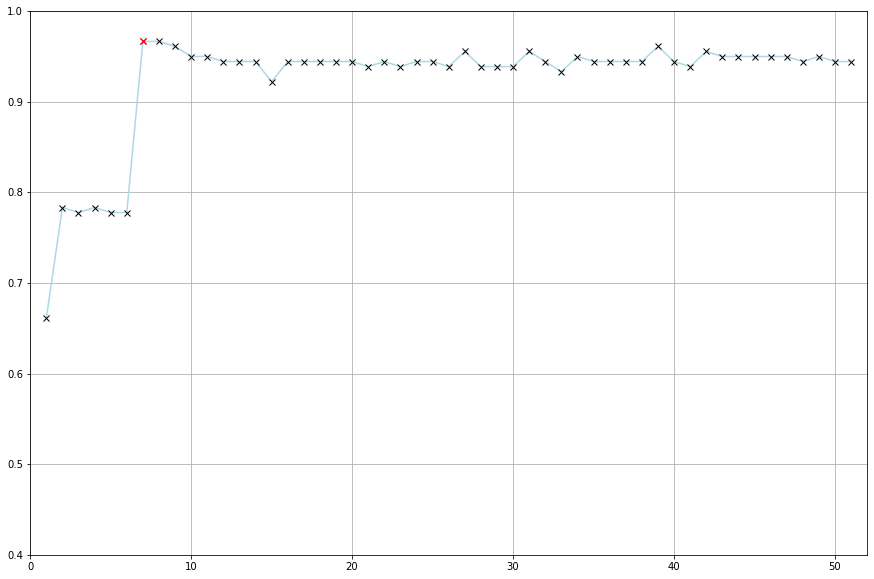

In [351]:
plt.figure(figsize=(15,10))
plt.grid()
plt.plot(range(1,52),accuracy_list, marker = 'x', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'black')
plt.plot(accuracy_list.index(max(accuracy_list)) + 1, accuracy_list[accuracy_list.index(max(accuracy_list))], marker = 'x', markeredgecolor = 'red', markerfacecolor = 'None')
plt.xlim([0,52])
plt.ylim([0.4,1])

In [352]:
print('highest accuracy model: ' + str(accuracy_list.index(max(accuracy_list)) + 1) + " " + str(max(accuracy_list)))
features = accuracy_list.index(max(accuracy_list)) + 1

highest accuracy model: 7 0.9666666666666667


In [363]:
from sklearn.tree import DecisionTreeClassifier
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=features)
rfe.fit(X_train, y_train)
for i in range(X_train.shape[1]):
    if(rfe.support_[i] == True):
        print('Column: %d, Rank: %.0f' % (i,  rfe.ranking_[i]) + " " + X_train.columns[i])

Column: 6, Rank: 1 timeSpentDead
Column: 15, Rank: 1 spell4Casts
Column: 20, Rank: 1 inhibitorKills
Column: 21, Rank: 1 towerKills
Column: 22, Rank: 1 damageToObjectives
Column: 23, Rank: 1 championKills
Column: 26, Rank: 1 champion2


Using the Recursive Feature Elimination on platinum ranked players we can see a large difference in terms of the factors that contribute to a win. From the graph, we can see that the optimal number of features that help predict the outcome of the game are 7. This in comparison to the 38 features needed to most effictively predict the outcome of an iron game shows that the importance of these 7 factors weigh more heavily in the outcome of a game in higher levels of play with other factor being more negligible. 

With only these 7 features we are able to predict the outcome of a game to an accuracy degree of approximately 96.7% which is higher than the max degree of accuracy we can achieve by analysing Iron players with the max accuracy being approximately 92.4%. Ultimately, this can show that it is slightly harder to predict the accurate outcome of an Iron match which implies that iron players have a less structured play style resulting in a greater uncertaintity in the outcome of the game. 

## Gaussian Naive Bayes

In [354]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

In [355]:
clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('accuracy: '+ str(accuracy))

accuracy: 0.7388888888888889


In [356]:
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
print('Gaussian Naive Bayes accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (scores.min(), scores.max(), scores.mean(), scores.std()))

Gaussian Naive Bayes accuracy range: [0.6111, 0.8310]; mean: 0.7292; std: 0.0639



The Iron model has higher model accuracy of 76.3% compared to Platinum's 73.9%. Although, Platinum demonstrates a lower standard deviation. This aligns with the consistency we have mentioned previously about Platinum's accuracy.
The results from the gaussian naive bayes underperform in our data analysis in comparison to the other models. Similarly, this is a result of the possibility that the data does not fit the density of a normal distribution resulting in a lower accuracy score. Our analysis will continue to use other models to see the varying degree of accuracy present in the platinum data set. 

## RandomForest

In [357]:
from sklearn.ensemble import ExtraTreesClassifier
scores = []
for i in range(10, 500, 30):
    forest = ExtraTreesClassifier(n_estimators=i, random_state=142)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    scores.append(accuracy)
    print(str(i) + ' estimator accuracy: '+ str(accuracy))

10 estimator accuracy: 0.9277777777777778
40 estimator accuracy: 0.9555555555555556
70 estimator accuracy: 0.9611111111111111
100 estimator accuracy: 0.9555555555555556
130 estimator accuracy: 0.9611111111111111
160 estimator accuracy: 0.9611111111111111
190 estimator accuracy: 0.9666666666666667
220 estimator accuracy: 0.9722222222222222
250 estimator accuracy: 0.9722222222222222
280 estimator accuracy: 0.9722222222222222
310 estimator accuracy: 0.9666666666666667
340 estimator accuracy: 0.9722222222222222
370 estimator accuracy: 0.9666666666666667
400 estimator accuracy: 0.9666666666666667
430 estimator accuracy: 0.9722222222222222
460 estimator accuracy: 0.9666666666666667
490 estimator accuracy: 0.9666666666666667


In [358]:
print('highest accuracy model: ' + str((scores.index(max(scores))*30) + 10) + " " + str(max(scores)))
estimators = (scores.index(max(scores))*30) + 10

highest accuracy model: 220 0.9722222222222222


In [359]:
forest = ExtraTreesClassifier(n_estimators = estimators, random_state=142)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
td = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
index = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, index[f], importances[index[f]]) + " " + X_train.columns[index[f]])

Feature ranking:
1. feature 48 (0.197748) firstInhibitor_cat
2. feature 21 (0.137266) towerKills
3. feature 6 (0.060002) timeSpentDead
4. feature 22 (0.057763) damageToObjectives
5. feature 20 (0.057747) inhibitorKills
6. feature 46 (0.052101) firstBaron_cat
7. feature 19 (0.033208) dragonKills
8. feature 49 (0.033172) firstTower_cat
9. feature 23 (0.028337) championKills
10. feature 18 (0.025576) baronKills
11. feature 0 (0.024692) gameDuration
12. feature 8 (0.013319) minionKills
13. feature 10 (0.012692) championLevel
14. feature 9 (0.012386) totalGold
15. feature 4 (0.011845) damageDealtToChampions
16. feature 16 (0.010710) summoner1Casts
17. feature 24 (0.010695) riftHeraldKills
18. feature 47 (0.010555) firstDragon_cat
19. feature 1 (0.010419) visionScore
20. feature 50 (0.009709) firstBlood_cat
21. feature 17 (0.009497) summoner2Casts
22. feature 5 (0.008070) totalHealing
23. feature 13 (0.007475) spell2Casts
24. feature 36 (0.007025) 1ban2
25. feature 15 (0.006976) spell4Casts


It can be seen that the feature ranking is quite similar to Iron's with some discrepancies. The features that demonstrate the highest importance tend to be objective related fields which indicates that the significance of taking objectives for all ranks.

The data analysed from the platinum players has yielded the same result indictating the most important factor in determining the outcome of the game is the firstInhibitor. However, when compared to iron players we can see that damageToObjectives is not very important as it is ranked at 4th feature. It should be noted that the time spent dead plays a larger role in higher ranks as shown by the ranking of importance. In iron timeSpentDead is the 6th most important feature whilst it is the third in higher ranks. This means that in higher ranked play teams who have spent less time dead have a higher chance of winning the game. 

## KNeighbors

In [360]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

k_range = range(1, 150, 5)
parameter_grid = {'n_neighbors':range(1, 150, 5)}
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy',cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_knn.fit(X_train, y_train)

print("Best K: ", gs_knn.best_params_['n_neighbors'])
print("Accuracy: ",gs_knn.best_score_)

Best K:  21
Accuracy:  0.8394561815336463


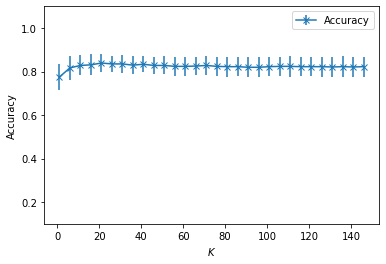

In [361]:
mean=gs_knn.cv_results_['mean_test_score']
std=gs_knn.cv_results_['std_test_score']

plt.errorbar(k_range, mean, yerr=std, marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('$K$')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

The Platinum model demonstrates greater consistency in model accuracy as K increases whereas the Iron model dips in accuracy around K = 70. Although, Iron has a higher model accuracy of approximately 84.7% at K = 16 whereas the Platinum model achieves 84% at K = 21.

# Discussion and Conclusion
We were able to form models that are able to accurately predict the outcome of the game in both Iron and Platinum.

Although, the features used are not far from expectation as the fields included in most cases, are good indicators for the direction a game is headed (e.g. the more resources a team has, it is obvious that they are more likely to win).

Some features had an impact that we were not expecting which we think are the main fruits of our analysis for example, in Platinum, the amount of times a team has used their 4th spell (their ultimate spell) was a prominent feature in the RFE Logistic Regression model.

The higher overall accuracy of the Platinum models showed the extent to which higher ranks are able to turn objectives into advantage. For example Platinum players are more likely to win from killing the baron first than if Iron players did.

This is also a result of the chaotic nature of Iron games where advantages do not always translate to winning (more likely to throw games).

As a whole we believe we were successful in our project in answering our predetermined questions and hope to potentially take it further in the future by analysing more ranks and including a larger set of records.
